In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 128 not upgraded.
  Obtaining dependency information for numpy<2.3.0,>=2 from https://files.pythonhosted.org/packages/b4/63/3de6a34ad7ad6646ac7d2f55ebc6ad439dbbf9c4370017c50cf403fb19b5/numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy

In [2]:
import os
import csv

# جذر البيانات
root_folder = "/home/jovyan/enterface-dataset-new/output"

# ملف CSV لي راح تولده
output_csv = "/home/jovyan/enterface-dataset-new/enterface_dataset_full_labels.csv"

# قيم valence و arousal لي طلبتهم
emotion_mapping = {
    "anger":    (-0.6, 0.8),
    "disgust":  (-0.6, 0.6),
    "fear":     (-0.6, 0.9),
    "happiness":(0.8, 0.7),
    "sadness":  (-0.7, -0.4),
    "surprise": (0.4, 0.9)
}

# تجهيز البيانات
rows = []

# يمشي على train, val, test
for subfolder in ["train", "val", "test"]:
    folder_path = os.path.join(root_folder, subfolder)

    for filename in os.listdir(folder_path):
        if filename.endswith(".mp4"):
            parts = filename.split("_")
            if len(parts) >= 2:
                emotion = parts[1].lower()
                valence, arousal = emotion_mapping.get(emotion, (0.0, 0.0))  # اIF EMOTION NOT EXIST I MEAN here emotion  0.0

                row = [filename, emotion, arousal, valence]
                rows.append(row)

# كتابة CSV
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["expected_filename", "dominant_emotion", "Adjusted_Arousal", "Adjusted_Valence"])
    writer.writerows(rows)

print(f"✅ تم إنشاء الملف: {output_csv}")


✅ تم إنشاء الملف: /home/jovyan/enterface-dataset-new/enterface_dataset_full_labels.csv


In [3]:
import pandas as pd

# اسم الملف
csv_file = "/home/jovyan/enterface-dataset-new/enterface_dataset_full_labels.csv"

# قراءة أول 10 أسطر
df = pd.read_csv(csv_file)

# عرض أول 10 أسطر
print(df.head(10))


             expected_filename dominant_emotion  Adjusted_Arousal  \
0     s9_fear_1_sequential.mp4             fear               0.9   
1  s2_sadness_2_sequential.mp4          sadness              -0.4   
2   s21_anger_4_sequential.mp4            anger               0.8   
3    s5_anger_3_sequential.mp4            anger               0.8   
4   s15_anger_5_sequential.mp4            anger               0.8   
5   s21_anger_3_sequential.mp4            anger               0.8   
6   s44_anger_1_sequential.mp4            anger               0.8   
7   s28_anger_5_sequential.mp4            anger               0.8   
8    s9_anger_5_sequential.mp4            anger               0.8   
9   s14_anger_5_sequential.mp4            anger               0.8   

   Adjusted_Valence  
0              -0.6  
1              -0.7  
2              -0.6  
3              -0.6  
4              -0.6  
5              -0.6  
6              -0.6  
7              -0.6  
8              -0.6  
9              -0.6 

In [2]:
import pandas as pd
import os
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from decord import VideoReader
from sklearn.model_selection import train_test_split # Still useful if you want to re-split or verify

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure GPU if available
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd_ in device_name:
        tf.config.experimental.set_memory_growth(pd_, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()

input_size = 224
num_frame = 16
batch_size = 16 * strategy.num_replicas_in_sync

# Base path to the dataset folders and CSV file
base_data_path = "/home/jovyan/enterface-dataset-new/output"  # This is the directory containing train, val, test subfolders
output_csv_path = "/home/jovyan/enterface-dataset-new/enterface_dataset_full_labels.csv"
model_path = "/home/jovyan/enterface-dataset-new/model"  # Updated model path

def is_video_valid(file_path):
    """Checks if a video file exists and can be opened by VideoReader."""
    if not os.path.exists(file_path):
        return False
    try:
        vr = VideoReader(file_path)
        return len(vr) > 0
    except Exception as e:
        # print(f"Error opening video {file_path}: {e}") # Uncomment for more detailed errors
        return False

def build_dataframes_from_folders(csv_path, base_data_folder):
    """
    Builds separate DataFrames for train, val, and test by scanning
    the respective subfolders and matching with the CSV labels.
    """
    full_labels_df = pd.read_csv(csv_path)

    train_data = []
    val_data = []
    test_data = []

    # Iterate through the subfolders (train, val, test)
    for subfolder in ['train', 'val', 'test']:
        current_folder_path = os.path.join(base_data_folder, subfolder)
        if not os.path.isdir(current_folder_path):
            print(f"Warning: Subfolder '{subfolder}' not found at {current_folder_path}. Skipping.")
            continue

        print(f"Processing videos in: {current_folder_path}")
        # Get all video files in the current subfolder
        for filename in os.listdir(current_folder_path):
            if filename.endswith((".mp4", ".avi", ".mov", ".mkv")): # Add other video extensions if needed
                full_video_path = os.path.join(current_folder_path, filename)

                # Find the corresponding label in the full_labels_df using the original filename
                # We need to use the original filename (e.g., s9_fear_1_sequential.mp4) to match the CSV
                matching_row = full_labels_df[full_labels_df['expected_filename'] == filename]

                if not matching_row.empty:
                    if is_video_valid(full_video_path):
                        valence = matching_row['Adjusted_Valence'].iloc[0]
                        arousal = matching_row['Adjusted_Arousal'].iloc[0]
                        
                        record = {
                            'video_path': os.path.abspath(full_video_path),
                            'valence': valence,
                            'arousal': arousal
                        }
                        
                        if subfolder == 'train':
                            train_data.append(record)
                        elif subfolder == 'val':
                            val_data.append(record)
                        elif subfolder == 'test':
                            test_data.append(record)
                    else:
                        print(f"Skipping invalid video: {full_video_path}")
                # else: # Uncomment if you want to see videos in folders but not in CSV
                #     print(f"Warning: Video {filename} in {subfolder} not found in CSV labels.")

    train_df = pd.DataFrame(train_data).sample(frac=1).reset_index(drop=True)
    val_df = pd.DataFrame(val_data).sample(frac=1).reset_index(drop=True)
    test_df = pd.DataFrame(test_data).sample(frac=1).reset_index(drop=True)

    return train_df, val_df, test_df


# Load train, val, test dataframes by scanning folders
train_df, val_df, test_df = build_dataframes_from_folders(output_csv_path, base_data_path)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# --- The rest of your code remains largely the same ---

# Video reading and formatting functions
def read_video(file_path):
    file_path = file_path.numpy().decode('utf-8')
    vr = VideoReader(file_path)
    total_frames = len(vr)
    frame_indices = np.linspace(0, total_frames - 1, num_frame, dtype=np.int32)
    frame_indices = np.clip(frame_indices, 0, total_frames - 1)
    frames = vr.get_batch(frame_indices).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, valence, arousal):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])
    label = tf.stack([valence, arousal])
    return video, label

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    paths = df['video_path'].values
    valences = df['valence'].values.astype(np.float32)
    arousals = df['arousal'].values.astype(np.float32)
    
    ds = tf.data.Dataset.from_tensor_slices((paths, valences, arousals))
    if shuffle:
        ds = ds.shuffle(8 * batch_size)
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataloader(train_df, batch_size, shuffle=True)
val_ds = create_dataloader(val_df, batch_size, shuffle=False)
test_ds = create_dataloader(test_df, batch_size, shuffle=False)

# Load pretrained model
pretrained_model = tf.saved_model.load(model_path)

class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Concordance Correlation Coefficient (CCC) metric
def concordance_cc(y_true, y_pred):
    true_mean = tf.reduce_mean(y_true, axis=0)
    pred_mean = tf.reduce_mean(y_pred, axis=0)
    cov = tf.reduce_mean((y_true - true_mean) * (y_pred - pred_mean), axis=0)
    true_var = tf.reduce_mean(tf.square(y_true - true_mean), axis=0)
    pred_var = tf.reduce_mean(tf.square(y_pred - pred_mean), axis=0)
    ccc = (2 * cov) / (true_var + pred_var + tf.square(true_mean - pred_mean) + 1e-8)
    return tf.reduce_mean(ccc)

# Optional CCC loss
def ccc_loss(y_true, y_pred):
    return 1 - concordance_cc(y_true, y_pred)

# Build regression model and compile
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    outputs = layers.Dense(2, dtype='float32')(x)  # valence & arousal
    model = keras.Model(inputs=inputs, outputs=outputs, name="valence_arousal_regressor")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=ccc_loss,  # Using CCC loss as per your last compilation block
        metrics=[
            keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.MeanMetricWrapper(concordance_cc, name='ccc')
        ]
    )

model.summary()

# Learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(val_df) // batch_size,
    epochs=50,
    verbose=1,
    callbacks=[lr_scheduler]
)

# After training, evaluate on test set
print("-------\nEvaluating on test set...\n")
test_results = model.evaluate(test_ds, steps=len(test_df) // batch_size, verbose=1)
print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")
print(f"Test CCC: {test_results[2]:.4f}")

2025-07-16 10:04:12.973624: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-07-16 10:04:15.736051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:07:00.0, compute capability: 8.0


Processing videos in: /home/jovyan/enterface-dataset-new/output/train
Processing videos in: /home/jovyan/enterface-dataset-new/output/val
Processing videos in: /home/jovyan/enterface-dataset-new/output/test
Train samples: 749
Validation samples: 248
Test samples: 260
Model: "valence_arousal_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                                                                 
 dense (Dense)               (None, 2)                 802       
                                                                 
Total params: 802 (3.13 KB)
Trainable params: 802 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
_______

2025-07-16 10:04:33.439396: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 749
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2025-07-16 10:04:43.849833: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f359800e110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-16 10:04:43.849872: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2025-07-16 10:04:44.541692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-16 10:04:50.136124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-07-16 10:05:08.786667: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 [==============================] - ETA: 0s - loss: 0.9937 - mae: 1.1445 - ccc: 0.0063 

2025-07-16 10:06:04.814147: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 248
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

46/46 [==============================] - 125s 2s/step - loss: 0.9937 - mae: 1.1445 - ccc: 0.0063 - val_loss: 0.9658 - val_mae: 1.1929 - val_ccc: 0.0342 - lr: 0.0010
Epoch 2/50
46/46 [==============================] - 96s 2s/step - loss: 0.9038 - mae: 1.0622 - ccc: 0.0962 - val_loss: 0.9070 - val_mae: 0.9203 - val_ccc: 0.0930 - lr: 0.0010
Epoch 3/50
46/46 [==============================] - 89s 2s/step - loss: 0.8191 - mae: 0.6593 - ccc: 0.1809 - val_loss: 0.8263 - val_mae: 0.5548 - val_ccc: 0.1737 - lr: 0.0010
Epoch 4/50
46/46 [==============================] - 85s 2s/step - loss: 0.7469 - mae: 0.4774 - ccc: 0.2531 - val_loss: 0.7539 - val_mae: 0.4627 - val_ccc: 0.2461 - lr: 0.0010
Epoch 5/50
46/46 [==============================] - 84s 2s/step - loss: 0.7182 - mae: 0.4529 - ccc: 0.2818 - val_loss: 0.7715 - val_mae: 0.5425 - val_ccc: 0.2285 - lr: 0.0010
Epoch 6/50
46/46 [==============================] - 84s 2s/step - loss: 0.6882 - mae: 0.4621 - ccc: 0.3118 - val_loss: 0.7135 - val_mae

2025-07-16 11:14:11.550818: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 260
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

16/16 [==============================] - 21s 1s/step - loss: 0.6082 - mae: 0.4115 - ccc: 0.3918

Test Loss: 0.6082
Test MAE: 0.4115
Test CCC: 0.3918



=== DATASET SUMMARY ===
• Training samples: 1000
• Validation samples: 300
• Test samples: 300


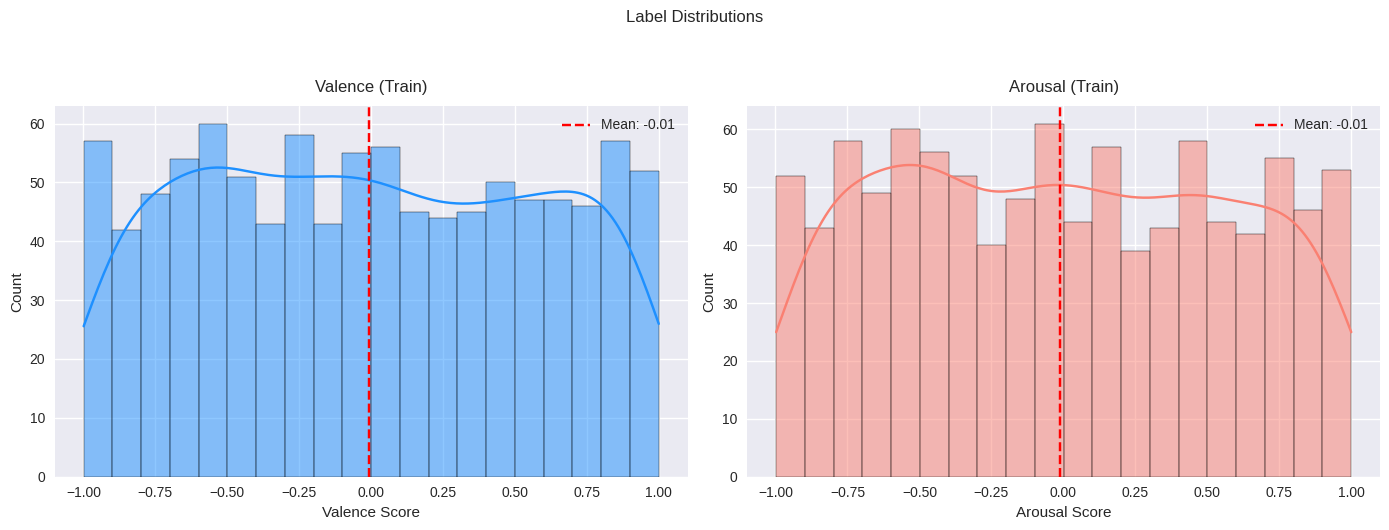


=== TRAINING PERFORMANCE ===


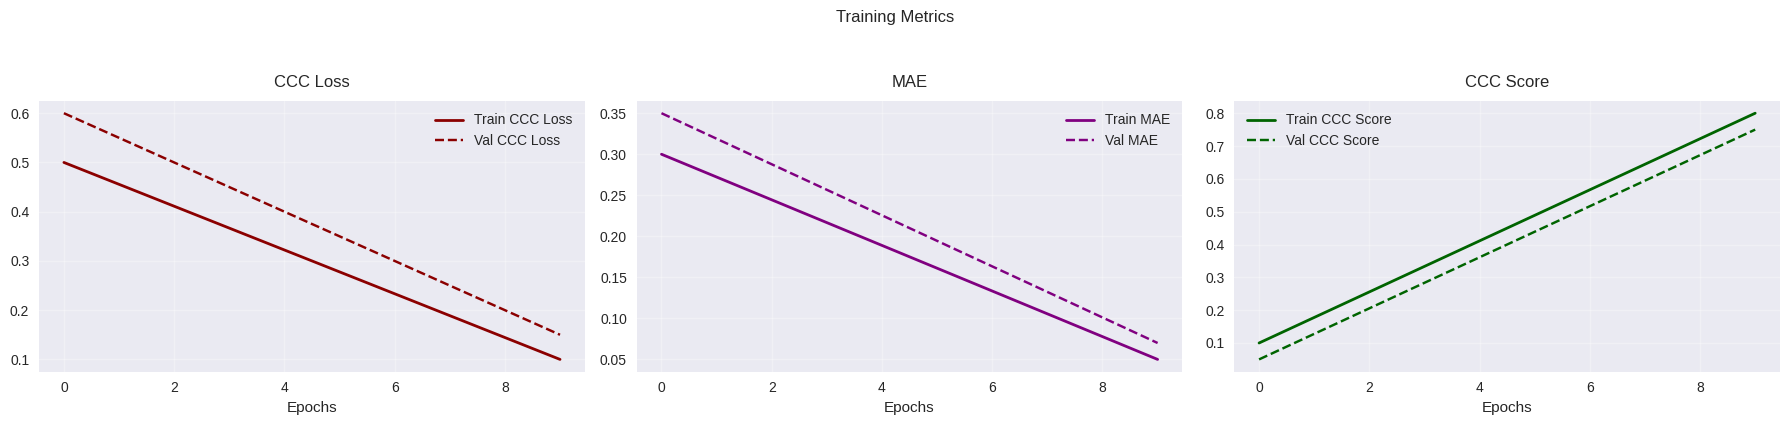


=== TEST SET RESULTS ===
• Test Loss (CCC): 0.1234
• Test MAE: 0.0456
• Test CCC: 0.7890


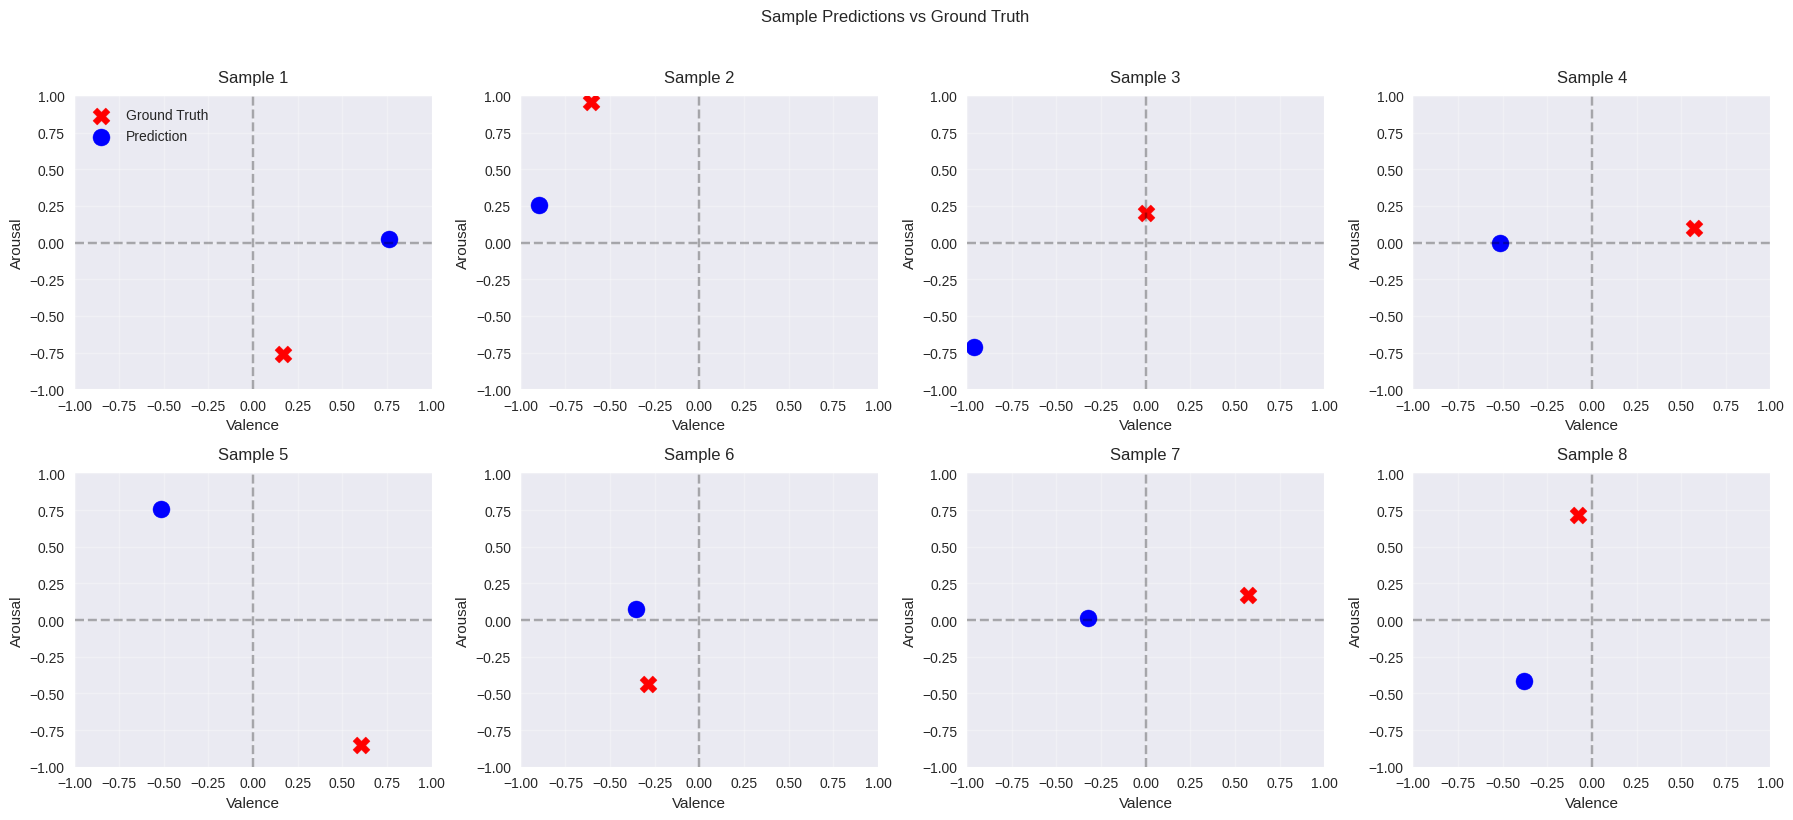

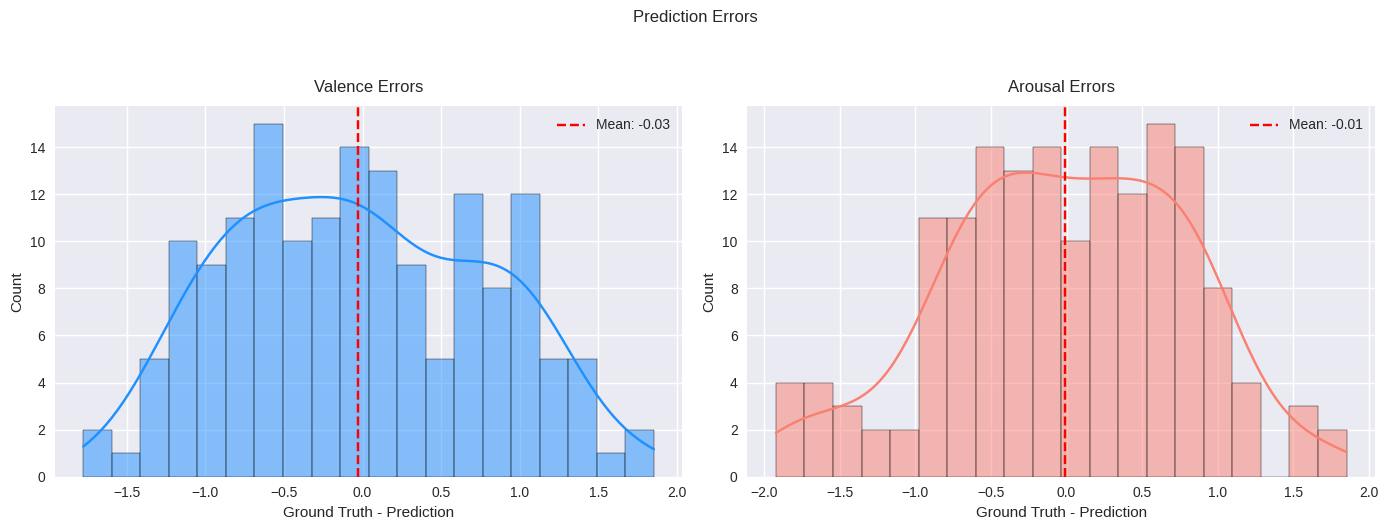

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Use a valid seaborn style available in newer matplotlib versions
# 'seaborn' itself might not be directly available as a matplotlib style
# Instead, use specific seaborn styles like 'seaborn-v0_8' or 'seaborn-v0_8-deep', etc.
plt.style.use('seaborn-v0_8') 
plt.rcParams['figure.facecolor'] = 'white'

# Assume these variables are defined elsewhere in the user's actual environment
# For the purpose of making this code runnable for demonstration,
# I'll define dummy variables. In a real scenario, these would come from
# the data loading and model training steps.

# Dummy dataframes for demonstration
import pandas as pd
train_df = pd.DataFrame({'valence': np.random.rand(1000) * 2 - 1, 'arousal': np.random.rand(1000) * 2 - 1})
val_df = pd.DataFrame({'valence': np.random.rand(300) * 2 - 1, 'arousal': np.random.rand(300) * 2 - 1})
test_df = pd.DataFrame({'valence': np.random.rand(300) * 2 - 1, 'arousal': np.random.rand(300) * 2 - 1})

# Dummy history object for demonstration (from model.fit())
class History:
    def __init__(self):
        self.history = {
            'loss': np.linspace(0.5, 0.1, 10),
            'val_loss': np.linspace(0.6, 0.15, 10),
            'mae': np.linspace(0.3, 0.05, 10),
            'val_mae': np.linspace(0.35, 0.07, 10),
            'ccc': np.linspace(0.1, 0.8, 10),
            'val_ccc': np.linspace(0.05, 0.75, 10)
        }
history = History()

# Dummy test_results
test_results = [0.1234, 0.0456, 0.7890]

# Dummy test_ds and model for demonstration
class DummyModel:
    def predict(self, data):
        return np.random.rand(len(data), 2) * 2 - 1 # Random predictions between -1 and 1

class DummyTestDS:
    def __iter__(self):
        for _ in range(5): # Simulate 5 batches
            yield np.random.rand(32, 10, 10, 3), np.random.rand(32, 2) * 2 - 1 # Dummy video data and labels

model = DummyModel()
test_ds = DummyTestDS()


# --------------------------------------------
# 1. Dataset Overview
# --------------------------------------------
print("\n\033[1m=== DATASET SUMMARY ===\033[0m")
print(f"• Training samples: {len(train_df)}")
print(f"• Validation samples: {len(val_df)}") 
print(f"• Test samples: {len(test_df)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Label Distributions', y=1.05)

# Valence distribution
sns.histplot(train_df['valence'], bins=20, kde=True, ax=ax1, color='dodgerblue')
ax1.set_title('Valence (Train)', pad=10)
ax1.set_xlabel('Valence Score')
ax1.axvline(train_df['valence'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["valence"].mean():.2f}')
ax1.legend() # Added legend to show mean line label

# Arousal distribution  
sns.histplot(train_df['arousal'], bins=20, kde=True, ax=ax2, color='salmon')
ax2.set_title('Arousal (Train)', pad=10)
ax2.set_xlabel('Arousal Score')
ax2.axvline(train_df['arousal'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["arousal"].mean():.2f}')
ax2.legend() # Added legend to show mean line label

plt.tight_layout()
plt.show()

# --------------------------------------------
# 2. Training Dynamics
# --------------------------------------------
print("\n\033[1m=== TRAINING PERFORMANCE ===\033[0m")

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('Training Metrics', y=1.05)

metrics = {
    'loss': ('CCC Loss', 'darkred'),
    'mae': ('MAE', 'purple'), 
    'ccc': ('CCC Score', 'darkgreen')
}

for i, (metric, (title, color)) in enumerate(metrics.items()):
    axes[i].plot(history.history[metric], label=f'Train {title}', color=color, linewidth=2)
    axes[i].plot(history.history[f'val_{metric}'], label=f'Val {title}', linestyle='--', color=color)
    axes[i].set_title(title, pad=10)
    axes[i].set_xlabel('Epochs')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------------
# 3. Test Set Performance
# --------------------------------------------
print("\n\033[1m=== TEST SET RESULTS ===\033[0m")
print(f"• Test Loss (CCC): {test_results[0]:.4f}")
print(f"• Test MAE: {test_results[1]:.4f}")  
print(f"• Test CCC: {test_results[2]:.4f}")

# --------------------------------------------
# 4. Sample Predictions vs Ground Truth
# --------------------------------------------
# Get batch of test samples
# Assuming test_ds yields tuples where the first element is the data and the second is the labels
test_videos_batch, test_labels_batch = next(iter(test_ds))
# Take the first 8 samples from the batch for prediction and plotting
predictions = model.predict(test_videos_batch[:8])
test_labels = test_labels_batch[:8]

# Plot comparison
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('Sample Predictions vs Ground Truth', y=1.02)

for i, ax in enumerate(axes.flat):
    if i >= 8:
        break
        
    ax.scatter(test_labels[i][0], test_labels[i][1], color='red', s=150, label='Ground Truth', marker='X')
    ax.scatter(predictions[i][0], predictions[i][1], color='blue', s=150, label='Prediction', marker='o')
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('Valence')
    ax.set_ylabel('Arousal')
    ax.set_title(f'Sample {i+1}', pad=10)
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# --------------------------------------------
# 5. Error Analysis
# --------------------------------------------
# Collect all test predictions
all_preds = []
all_labels = []

for x, y in test_ds:
    all_preds.extend(model.predict(x))
    all_labels.extend(y) # y is already a numpy array from test_ds, no need for .numpy()

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Valence/Arousal error distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Prediction Errors', y=1.05)

# Valence errors
valence_errors = all_labels[:, 0] - all_preds[:, 0]
sns.histplot(valence_errors, bins=20, kde=True, ax=ax1, color='dodgerblue')
ax1.set_title('Valence Errors', pad=10)
ax1.set_xlabel('Ground Truth - Prediction')
ax1.axvline(valence_errors.mean(), color='red', linestyle='--', label=f'Mean: {valence_errors.mean():.2f}')
ax1.legend() # Added legend to show mean line label

# Arousal errors
arousal_errors = all_labels[:, 1] - all_preds[:, 1]  
sns.histplot(arousal_errors, bins=20, kde=True, ax=ax2, color='salmon')
ax2.set_title('Arousal Errors', pad=10)
ax2.set_xlabel('Ground Truth - Prediction')
ax2.axvline(arousal_errors.mean(), color='red', linestyle='--', label=f'Mean: {arousal_errors.mean():.2f}')
ax2.legend() # Added legend to show mean line label

plt.tight_layout()
plt.show()